In [16]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder

In [17]:
class CleanImageFolder(ImageFolder):
    def find_classes(self, directory):
        IMG_EXT = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp')
        classes = []
        class_to_idx = {}
        # Scan immediate subdirectories of 'directory'
        for entry in os.scandir(directory):
            if entry.is_dir():
                has_image = False
                # Check files inside this folder
                for f in os.listdir(entry.path):
                    if f.lower().endswith(IMG_EXT):
                        has_image = True
                        break
                if has_image:
                    classes.append(entry.name)
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

In [21]:
DATA_DIR = r"E://Projects//paddydisease"   # your dataset root
BATCH_SIZE = 32
NUM_EPOCHS = 30
IMG_SIZE = 128
MAX_IMAGES_PER_CLASS = 450
BEST_MODEL_PATH = "best_paddy_model.pth"

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

Using device: cuda


In [23]:
full_dataset = CleanImageFolder(DATA_DIR, transform=transform)
NUM_CLASSES = len(full_dataset.classes)

print("Valid classes found:", full_dataset.classes)
print("Total images (before limiting):", len(full_dataset))

Valid classes found: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'black_stem_borer', 'blast', 'brown_spot', 'downy_mildew', 'hispa', 'leaf_roller', 'normal', 'tungro', 'white_stem_borer', 'yellow_stem_borer']
Total images (before limiting): 16225


In [24]:
class_indices = {cls: [] for cls in range(NUM_CLASSES)}

for idx, (_, label) in enumerate(full_dataset):
    class_indices[label].append(idx)

selected_indices = []
for cls, indices in class_indices.items():
    random.shuffle(indices)
    selected_indices.extend(indices[:MAX_IMAGES_PER_CLASS])

limited_dataset = Subset(full_dataset, selected_indices)

train_size = int(0.8 * len(limited_dataset))
test_size = len(limited_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    limited_dataset, [train_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"After limiting:")
print(f"  Total images: {len(limited_dataset)}")
print(f"  Train: {len(train_dataset)}, Test: {len(test_dataset)}")

After limiting:
  Total images: 5850
  Train: 4680, Test: 1170


In [26]:
class PaddyCNN(nn.Module):
    def __init__(self, num_classes):
        super(PaddyCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = PaddyCNN(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
train_losses = []
train_accuracies = []
test_accuracies = []
best_epoch = -1
best_test_acc = 0.0
best_train_loss = float("inf")

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0.0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    train_acc = correct / len(train_dataset)

    model.eval()
    correct_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()

    test_acc = correct_test / len(test_dataset)

    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}] - "
          f"Loss: {avg_loss:.4f} - "
          f"Train Acc: {train_acc:.4f} - "
          f"Test Acc: {test_acc:.4f}")

    # save best model
    if test_acc > best_test_acc or (test_acc == best_test_acc and avg_loss < best_train_loss):
        best_epoch = epoch + 1
        best_test_acc = test_acc
        best_train_loss = avg_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"Best model saved at epoch {best_epoch}")

print(f"\nBest Epoch: {best_epoch} | "
      f"Train Loss: {best_train_loss:.4f} | "
      f"Test Accuracy: {best_test_acc:.4f}")


Epoch [1/30] - Loss: 2.3132 - Train Acc: 0.2226 - Test Acc: 0.2966
Best model saved at epoch 1
Epoch [2/30] - Loss: 1.7488 - Train Acc: 0.4318 - Test Acc: 0.4581
Best model saved at epoch 2
Epoch [3/30] - Loss: 1.3419 - Train Acc: 0.5709 - Test Acc: 0.5769
Best model saved at epoch 3
Epoch [4/30] - Loss: 0.9401 - Train Acc: 0.7038 - Test Acc: 0.6137
Best model saved at epoch 4
Epoch [5/30] - Loss: 0.5659 - Train Acc: 0.8252 - Test Acc: 0.6556
Best model saved at epoch 5
Epoch [6/30] - Loss: 0.3341 - Train Acc: 0.8957 - Test Acc: 0.7017
Best model saved at epoch 6
Epoch [7/30] - Loss: 0.1715 - Train Acc: 0.9470 - Test Acc: 0.7231
Best model saved at epoch 7
Epoch [8/30] - Loss: 0.1011 - Train Acc: 0.9756 - Test Acc: 0.7419
Best model saved at epoch 8
Epoch [9/30] - Loss: 0.0704 - Train Acc: 0.9831 - Test Acc: 0.7239
Epoch [10/30] - Loss: 0.0747 - Train Acc: 0.9816 - Test Acc: 0.7085
Epoch [11/30] - Loss: 0.0495 - Train Acc: 0.9893 - Test Acc: 0.6940
Epoch [12/30] - Loss: 0.0568 - Train 

<Figure size 1000x1000 with 0 Axes>

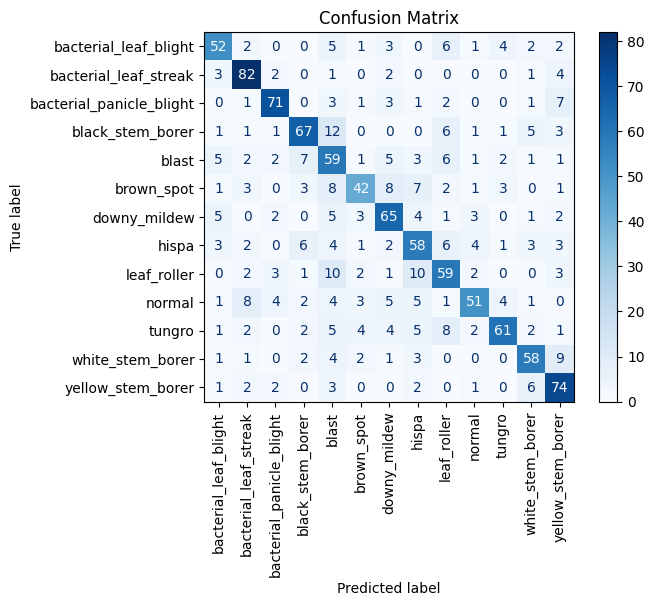

In [28]:
model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        all_probs.append(probs)
        all_labels.extend(labels.numpy())

all_probs = np.concatenate(all_probs, axis=0)
all_labels = np.array(all_labels)

preds = np.argmax(all_probs, axis=1)
cm = confusion_matrix(all_labels, preds)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=full_dataset.classes
)

plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.xticks(rotation=90)
plt.title("Confusion Matrix")
plt.show()